In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [87]:
class RNN:
    # Weights
    W = []
    # Layers
    M = []
    # Bias
    b = []
    # Activation function for each layer
    A = []
    Yhat = []
    costs = []
    lossType = 'mse'
    optimizer = 'none'
    
    def __init__(self):
        self.reset()
    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __tanh(self, Z):
        return np.tanh(Z)
    
    def __relu(self,Z):
        return Z * (Z > 0)
    
    # Calls specified activation function
    def __actf(self,Z,ty):
        if ty == 'sigmoid':
            return self.__sigmoid(Z)
        elif ty == 'tanh':
            return self.__tanh(Z)
        elif ty == 'softmax':
            return self.__softmax(Z)
        elif ty == 'none':
            return Z
        else:# ty == 'relu':
            return self.__relu(Z)
        
        # Calls specified activation function derivative
    def __actf_dv(self,Z,ty):
        if ty == 'sigmoid':
            return Z*(1-Z)
        elif ty == 'tanh':
            return (1-Z*Z)
        elif ty == 'none':
            return Z
        else:# ty == 'relu':
            return np.where(Z > 0, 1, 0)
        
    def __softmax(self,A):
        expA = np.exp(A)
        return expA / expA.sum(axis=1,keepdims=True)
    
    # Cross-entropy cost for softmax
    def __cost(self,T,Y,ty):
        if ty == 'ce':
            return self.__cross_entropy(T,Y)
        elif ty == 'mse':
            return self.__mean_squared(T,Y)
    
    def __cross_entropy(self,T,Y):
        tot = (-T * np.log(Y))
        return tot.sum()
    
    def __mean_squared(self,T,Y):
        tot = np.square(T - Y)
        return tot.sum()
    
    def classification_rate(self,T):
        Yhat = NeuralNetwork.Yhat
        Yp = np.argmax(Yhat,axis=1)
        print('Classification rate: ', np.mean(T == Yp))
    
    # Adds hidden layer with L nodes, d dropout
    def add_layer(self,L,a='sigmoid'):
        self.M.append(L)
        self.A.append(a)
        
    def __shuffle(self,X,Y):
        assert len(X) == len(Y)
        p = np.random.permutation(len(X))
        return X[p],Y[p]
    
    def __weights_rms_W(W,wCache,dw,decay,reg,eps):
        wCache = (decay * wCache) + (1-decay) * np.square(dw)
        wDenominator = np.sqrt(wCache) + eps
        W += l * ((dw/wDenominator) - reg*W)
        return W,wCache
    
    def __weights_rms_b(b,bCache,db):
        bCache = (decay * bCache) + (1-decay) * np.square(db)
        bDenominator = np.sqrt(bCache) + eps
        b += l * ((db/bDenominator) - reg*b)
        return b,bCache
    
    def __weights_adam_W(W,wM,wV,dw,decay,reg,epochs,eps):
        wM = (decay1 * wM) + (1-decay1) * dw
        wV = (decay1 * wV) + (1-decay1) * np.square(dw)
        wMhat = wM/(1-decay**(epochs+1))
        wVhat = wV/(1-decay**(epochs+1))
        wDenom = np.sqrt(wVhat) + eps
        W += l * ((wMhat/wDenom) - reg*W)
        return W,wM,wV
    
    def __weights_adam_b(b,bM,bV,db,decay,reg,epochs,eps):
        bM = (decay2 * bM) + (1-decay) * db
        bV = (decay2 * bV) + (1-decay) * np.square(db)
        bMhat = bM/(1-decay2**(epochs+1))
        bVhat = bV/(1-decay2**(epochs+1))
        bDenom = np.sqrt(bVhat) + eps
        b += l * ((bMhat/bDenom) - reg*b)
        return b,bM,bV
            
    # Parameters(M:Layers,W:Weights,b:bias,A:activation function,D:Dropout)
    def __forward(self,M,W,b,Y,A):
        Yp = np.zeros_like(Y)
        yp = np.zeros_like(Y)
        ht_arr = np.zeros((190,11,15,1))
        yt = np.zeros((190,10,1))
        X = M[0]#.reshape(-1,T,1)

        for i in range(len(X)):
            ht_prev = M[1][i]
            for t in range(len(X[i])):
                ht = self.__actf((X[i][t].dot(W[0]) + ht_prev.dot(W[1]) + b[0]), A[0])
                yp[i] = (ht.dot(W[2]) + b[1])
                ht_arr[i][t] = ht.reshape(-1,1)
                yt[i][t] = yp[i].reshape(-1,1)
                ht_prev = ht

            Yp[i] = yp[i]
        return Yp,M,ht_arr,yt
    
    def fit(self,X,Y,seq_len=10,epochs=20000,batchSize=0,learnR=10e-6,reg=0,lossType='mse',optimizer='none'):
        W = self.W
        b = self.b
        M = self.M
        A = self.A
        self.optimizer = optimizer
        self.lossType = lossType
        
        N = X.shape[0]
        
        # Regulate batch size
        batchSize = min(batchSize, N)
        batchSize = max(batchSize, 1)
        
        # Initialize layers for M
        for i in range(len(M)):
            M[i] = np.random.randn(batchSize,M[i])
        #M[0] = np.random.randn(batchSize,M[0])
            
        # Add input and layer to M
        K = Y.shape[1]
        M.insert(0,X)
        M.append(np.random.randn(batchSize,K))
        A.append('none')
        l = learnR
        
            
        # Set weights
        for i in range(len(M)-1):
            if i == (len(M)-2):

                W.append(np.random.randn(M[i].shape[1],K) / np.sqrt(M[i].shape[1] + K))
                b.append(np.random.randn(K) / np.sqrt(K))
            else:
                if i == 0:
                    # input to hidden
                    W.append(np.random.randn(M[i].shape[2],M[i+1].shape[1]) / np.sqrt(M[i].shape[2] + M[i+1].shape[1]))
                    b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))
                # hidden to hidden
                W.append(np.random.randn(M[i+1].shape[1],M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1] + M[i+1].shape[1]))
        # Set cache (if using rmsprop/adam)
        if optimizer == 'rms':
            wCache = []
            bCache = []
            eps = 10e-8
            decay = 0.99
            for i in range(len(M)-1):
                if i == (len(M)-2):
                    wCache.append(np.ones((M[i].shape[1],K)))
                    bCache.append(np.ones((K)))
                else:
                    wCache.append(np.ones((M[i].shape[2],M[i+1].shape[1])))
                    bCache.append(np.ones((M[i+1].shape[1])))
                    # hidden to hidden
                    WCache.append(np.ones((M[i+1].shape[1],M[i+1].shape[1])))
        elif optimizer == 'adam':
            wM = []
            wV = []
            bM = []
            bV = []
            eps = 10e-8
            decay1 = 0.9
            decay2 = 0.999
            for i in range(len(M)-1):
                if i == (len(M)-2):
                    # hidden to output
                    wM.append(np.zeros((M[i].shape[1],K)))
                    wV.append(np.zeros((M[i].shape[1],K)))
                    bM.append(np.zeros((K)))
                    bV.append(np.zeros((K)))
                else:
                    # prev layer to hidden
                    wM.append(np.zeros((M[i].shape[2],M[i+1].shape[1])))
                    wV.append(np.zeros((M[i].shape[2],M[i+1].shape[1])))
                    bM.append(np.zeros((M[i+1].shape[1])))
                    bV.append(np.zeros((M[i+1].shape[1])))
                    # hidden to hidden
                    wM.append(np.zeros((M[i+1].shape[1],M[i+1].shape[1])))
                    wV.append(np.zeros((M[i+1].shape[1],M[i+1].shape[1])))
        
        costs = []
        for e in range(epochs):
            iterations = N // batchSize
            #X,Y,y = self.__shuffle(X,Y,y)
            for i in range(iterations):
                start = i * batchSize
                end = (i+1) * batchSize
                batchX, batchY = X[start:end],Y[start:end]
                del M[0]
                #print(i)
                #print(X.shape, batchX.shape, start, end)
                M.insert(0,batchX)
                #print(sparceY)
                Yp,Z,ht,yt,cost = self.__forward(M,W,b,batchY,A)

                #Z = M
                #cost = self.__cost(Y,Yp)
                cost = self.__cost(batchY,Yp,lossType)
                costs.append(cost)
                

                #for j in range(len(M[0])):
                    #Z[0] = M[0][j]
                # Adjust weights
                #S = (Y - Yp)
                for i in range(batchX.shape[0]-1,-1,-1):
                    dwhy, dwby, dwhh = np.zeros_like(W[2]),np.zeros_like(b[1]),np.zeros_like(W[1])
                    dwbh, dwxh = np.zeros_like(b[0]),np.zeros_like(W[0])
                    dnext = np.zeros_like(W[2]) 
                    for t in range(T-1,-1,-1):
                        #print(i, t, yt[i][t])
                        zt = (Y[i] - yt[i][t]).reshape(1,-1)
                        dwo = (2/N) * ht[i][t].dot(zt)
                        db1 = zt.sum()
                        zt = (W[2].dot(zt) + dnext)*self.__actf_dv(ht[i][t], A[0])
                        dwhy += dwo
                        dwby += db1
                        #W[2] += dwo
                        #b[1] += db1
                        dxh = (2/N) * M[0][i][t].dot(zt.T)
                        dhh = (2/N) * ht[i][t-1].dot(zt.T)
                        db0 = zt.sum()
                        dwhh += dhh
                        dwxh += dxh
                        dwbh += db0
                        #W[1] += dhh
                        #W[0] += dxh
                        #b[0] += db0
                        dnext = W[1].dot(zt)
                    for param in [dwhy, dwby, dwhh, dwxh, dwbh]:
                        np.clip(param, -5, 5, out=param)
                        
                    # Optimizers
                    if optimizer == 'none':
                        W[2] += l * (dwhy - reg*W[2])
                        b[1] += l * (dwby - reg*b[1])
                        W[1] += l * (dwhh - reg*W[1])
                        b[0] += l * (dwbh - reg*b[0])
                        W[0] += l * (dwxh - reg*W[0])
                    elif optimizer == 'rms':
                        W[2],wCache[2] = self.__weights_rms_W(W[2],wCache[2],dwhy,decay,reg,eps)
                        W[1],wCache[1] = self.__weights_rms_W(W[1],wCache[1],dwhh,decay,reg,eps)
                        W[0],wCache[0] = self.__weights_rms_W(W[0],wCache[0],dwxh,decay,reg,eps)
                        b[1],bCache[1] = self.__weights_rms_b(b[1],bCache[1],dwby,decay,reg,eps)
                        b[0],bCache[0] = self.__weights_rms_b(b[0],bCache[0],dwbh,decay,reg,eps)
                    elif optimizer == 'adam':
                        W[2],wM[2],wV[2] = self.__weights_adam_W(W[2],wM[2],wV[2],dwhy,decay1,reg,epochs,eps)
                        W[1],wM[1],wV[1] = self.__weights_adam_W(W[1],wM[1],wV[1],dwhh,decay1,reg,epochs,eps)
                        W[0],wM[0],wV[0] = self.__weights_adam_W(W[0],wM[0],wV[0],dwxh,decay1,reg,epochs,eps)
                        b[1],bM[1],bV[1] = self.__weights_adam_b(b[1],bM[1],bV[1],dwby,decay2,reg,epochs,eps)
                        b[0],bM[0],bV[0] = self.__weights_adam_b(b[0],bM[0],bV[0],dwbh,decay2,reg,epochs,eps)

            if e % 500 == 0:
                print(e,costs[-1])
                plt.plot(Yp)
        self.W = W
        self.b = b
        self.M = M
        self.Yhat = Yp
        self.costs = costs
    
    def predict(self,X):
        W = self.W
        b = self.b
        M = self.M
        A = self.A
        del M[0]
        M.insert(0,X)
        Yp,Z = self.__forward(M,W,b,A,D)
        NeuralNetwork.Yhat = Yp
        return Yp
    
    def plot_cost(self):
        costs = self.costs
        plt.plot(costs)
        plt.show()
    
    def reset(self):
        self.W = []
        self.b = []
        self.M = []
        self.A = []
        self.lossType = 'mse'
        self.optimizer = 'none'
        self.Yhat = []
        self.costs = []

In [88]:
series = np.sin(0.1*np.arange(200))

In [89]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(len(Y),-1)
N = len(X)

In [111]:
model = RNN()

In [112]:
model.add_layer(15,'tanh')

0 342.4767756044993
500 3.605153958010921
1000 3.3648801554180743
1500 3.270268123825591


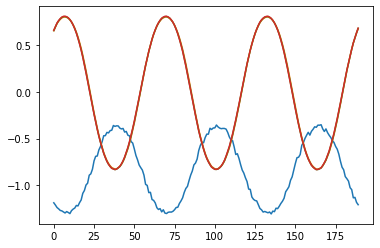

In [113]:
# (X, Y, loss type, # iterations, batch size, learning rate, regulization)
# Loss type('ce': cross-entropy, 'sce': sparse cross-entropy)
lossType = 'mse'
seq_len = 10
epochs = 20000
batchSize = N
learnR = 10e-4
reg = 0
optimizer = 'none'
model.fit(X,Y,seq_len,2000,batchSize,learnR,lossType=lossType,optimizer=optimizer)

In [56]:
M = model.M
W = model.W

In [99]:
M[2].shape

(1, 1)

In [114]:
yp = model.Yhat

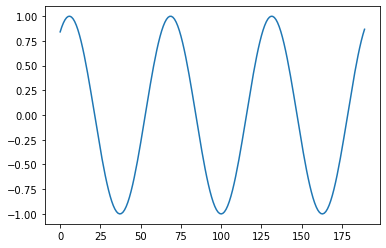

In [115]:
plt.plot(Y)

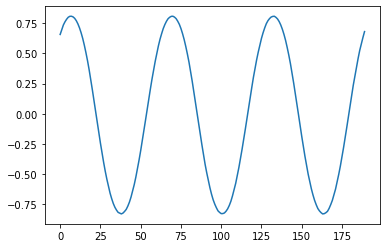

In [116]:
plt.plot(yp)

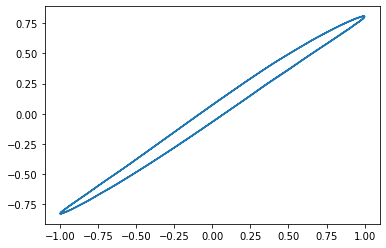

In [117]:
plt.plot(Y,yp)

## Individual methods / testing

In [11]:
def forward(M,W,b):
    X = M[0].reshape(-1,T,1)
    Y = []
    yp = []
    ht_prev = M[1][0]
    for i in range(len(X)):
        ht = tanh((X[i].T.dot(W[0]) + ht_prev.dot(W[1]) + b[0]))
        yp.append(ht.dot(W[2]) + b[1])
        #yp = softmax(yp)
        ht_prev = ht
        M[1][i] = ht
        Y.append(yp[i])
    
    Y = np.array(Y).reshape(len(Y),-1)               
    return Y,M

In [12]:
def mse(T,Y):
    tot = np.square(T - Y)
    return tot.sum()

In [13]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [14]:
def tanh(Z):
    return np.tanh(Z)

In [15]:
def actf_dv(Z):
    return Z*(1-Z)

In [16]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1,keepdims=True)

In [17]:
series = np.sin(0.1*np.arange(200))

In [26]:
T = 10
H = 15
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(len(Y),-1)
N = len(X)

In [18]:
seq_len = 10
H = 15
X = []
Y = []
for t in range(len(series) - seq_len):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
X = np.array(X).reshape(len(X),-1)
Y = np.array(Y).reshape(len(Y),-1)

In [182]:
X.reshape(len(X),-1).shape

(190, 10)

In [44]:
for j in range(M[0].shape[0]):
    print(M[0][j])

[[0.        ]
 [0.09983342]
 [0.19866933]
 [0.29552021]
 [0.38941834]
 [0.47942554]
 [0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]]
[[0.09983342]
 [0.19866933]
 [0.29552021]
 [0.38941834]
 [0.47942554]
 [0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]
 [0.84147098]]
[[0.19866933]
 [0.29552021]
 [0.38941834]
 [0.47942554]
 [0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]
 [0.84147098]
 [0.89120736]]
[[0.29552021]
 [0.38941834]
 [0.47942554]
 [0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]
 [0.84147098]
 [0.89120736]
 [0.93203909]]
[[0.38941834]
 [0.47942554]
 [0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]
 [0.84147098]
 [0.89120736]
 [0.93203909]
 [0.96355819]]
[[0.47942554]
 [0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]
 [0.84147098]
 [0.89120736]
 [0.93203909]
 [0.96355819]
 [0.98544973]]
[[0.56464247]
 [0.64421769]
 [0.71735609]
 [0.78332691]
 [0.84147098]
 [0.89120736]
 [0.93203909]
 [0.96355819]
 [0.98544973]
 [0.99749499]]
[[0.64421769]

In [27]:
# Initialize layers for M
M = []
W = []
b = []
M.append(np.zeros((N,H)))

# Add input and layer to M
K = 1
M.insert(0,X)
M.append(np.random.randn(N,K))

In [28]:
# Set weights
W = []
b = []
for i in range(len(M)-1):
    if i == (len(M)-2):
        
        W.append(np.random.randn(M[i].shape[1],K) / np.sqrt(M[i].shape[1] + K))
        b.append(np.random.randn(K) / np.sqrt(K))
    else:
        # input to hidden
        W.append(np.random.randn(M[i].shape[1],M[i+1].shape[1]) / np.sqrt(M[i].shape[1] + M[i+1].shape[1]))
        #b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))
        # hidden to hidden
        W.append(np.random.randn(M[i+1].shape[1],M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1] + M[i+1].shape[1]))
        b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))

In [35]:
X.shape[0]

190

In [51]:
W[2].shape

(15, 1)

In [20]:
b3 = np.random.randn(1,10,15)

In [15]:
ht = tanh((M[0][0].dot(W[0]) + M[1][0].dot(W[1]) + b[0]))

In [76]:
W[1].shape

(15, 15)

In [78]:
Yp,M = forward(M,W,b)

In [65]:
yp1 = np.zeros_like(Y)

In [67]:
yp1.shape

(190, 1)

In [14]:
W[0].shape

(1, 15)

In [38]:
M[0].shape

(190, 10, 1)

In [22]:
zt = (Y-Yp)

In [24]:
dw = (2/N) * M[2].T.dot(zt)

In [26]:
zt1 = (zt).dot(W[2].T)*tanh(M[2])

In [27]:
dw1 = (2/N) * M[1].T.dot(zt1)

In [29]:
dw2 = (2/N) * M[0].T.dot(zt1)

In [32]:
W[0].shape

(1, 15)

In [34]:
zt1.shape

(190, 15)

In [49]:
mlast = [i[-1] for i in M[0]]
mlast = np.array(mlast)

In [54]:
M[0][2][-1]

array([0.89120736])

In [55]:
mlast.shape

(190, 1)

In [97]:
x = np.random.randn((50))

In [100]:
x.dot(x)

38.590652295603974

In [18]:
Z = M[1]
Zt = Y

In [19]:
b1 = b[1]
b0 = b[0]

In [20]:
Z = M

In [21]:
w2 = np.vstack([b1,W[2]])
w1 = np.vstack([b0,W[1]])
z2 = np.vstack([np.ones((len(Z[2][0]))),Z[2]])
z1 = np.vstack([np.ones((len(Z[1][0]))),Z[1]])

In [32]:
z1.shape

(191, 15)

In [30]:
Y1 = np.vstack([np.ones(1),Y])

In [89]:
b2.shape

(1,)

In [33]:
dw = np.linalg.solve(np.dot(z2.T, z2), np.dot(z2.T, Y1))

In [15]:
dw1 = np.linalg.solve(np.dot(Yp.T, Yp), np.dot(Yp.T, Y))

In [36]:
dw

array([[0.00980991]])

In [16]:
dw1

array([[0.00013429]])